# Measuring Learning Outcomes for Pretest and Postest

Connectedness: checking if solutions are spanning or not
out of the connected, is_mst

Optimality: check is_mst
how close was the solution to the correct solution quantified by the error

In [1]:
import pathlib as pl
import pickle
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import wilcoxon, shapiro, ttest_rel
# import cliffs delta
from effsize.effsize import two_group_difference

# Define paths.

In [2]:
processed_tables_pickle_file = pl.Path(
    '../processed_data/processed_tables.pickle')

learning_df_pickle_file = pl.Path(
    '../processed_data/learning_df.pickle')


# Load pickled data.

In [3]:
with processed_tables_pickle_file.open('rb') as handle:
    processed_tables = pickle.load(handle)

In [4]:
processed_tables.keys()
pd.options.display.max_rows = None
processed_tables[10]

,Time,header.seq,header.frame_id,state.edges,state.suggested.u,state.suggested.v,state.terminal,state.submit_suggested,action.agent_name,action.type,...,next_state.terminal,next_state.submit_suggested,action_no,step_no,turn_agent,world_state,action,is_submission,cost,is_mst
0,0.000000,1,indiv-illustrate,[],-1,-1,False,False,human,1,...,False,False,0,1,human,"NetworkState(e:0+1,c:0|n:2,e:1;s:0)","pick(9,1)",False,0,False
1,35.210591,2,indiv-illustrate,[u: 9\nv: 1],-1,-1,False,False,human,8,...,False,False,1,2,human,"NetworkState(e:1+1,c:3|n:2,e:1;s:1)",clear,False,3,True
2,63.511856,3,indiv-illustrate,[],-1,-1,False,False,human,1,...,False,False,2,3,human,"NetworkState(e:0+1,c:0|n:2,e:1;s:0)","pick(9,1)",False,0,False
3,64.949268,4,indiv-illustrate,[u: 9\nv: 1],-1,-1,False,False,human,3,...,True,False,3,4,human,"NetworkState(e:1+1,c:3|n:2,e:1;s:1)",submit,False,3,True
4,110.073297,5,pretest-1,[],-1,-1,False,False,human,1,...,False,False,0,0,human,"NetworkState(e:0+1,c:0|n:7,e:12;s:0)","pick(6,4)",False,0,False
5,119.051472,6,pretest-1,[u: 6\nv: 4],-1,-1,False,False,human,1,...,False,False,1,0,human,"NetworkState(e:1+1,c:2|n:7,e:12;s:0)","pick(4,5)",False,2,False
6,132.143539,7,pretest-1,"[u: 4\nv: 5, u: 6\nv: 4]",-1,-1,False,False,human,1,...,False,False,2,0,human,"NetworkState(e:2+1,c:4|n:7,e:12;s:0)","pick(5,7)",False,4,False
7,158.369589,8,pretest-1,"[u: 4\nv: 5, u: 6\nv: 4, u: 5\nv: 7]",-1,-1,False,False,human,1,...,False,False,3,0,human,"NetworkState(e:3+1,c:7|n:7,e:12;s:0)","pick(1,4)",False,7,False
8,165.098470,9,pretest-1,"[u: 4\nv: 5, u: 1\nv: 4, u: 6\nv: 4, u: 5\nv: 7]",-1,-1,False,False,human,1,...,False,False,4,0,human,"NetworkState(e:4+1,c:10|n:7,e:12;s:0)","pick(3,0)",False,10,False
9,169.787329,10,pretest-1,"[u: 4\nv: 5, u: 1\nv: 4, u: 6\nv: 4, u: 5\nv: ...",-1,-1,False,False,human,1,...,False,False,5,0,human,"NetworkState(e:5+1,c:13|n:7,e:12;s:0)","pick(1,3)",False,13,False


# Cleaning tables.

In [5]:
# Getting the submission states only and dropping the duplicates, unnecessary columns, keep state, activity, imported info
def clean_tables():
    student_tables = {}
    for student, df in processed_tables.items():

        df = df.copy()
        df = df[df['is_submission']]

        df.drop(['Time', 'header.seq', 'state.edges', 'state.suggested.u', 'state.suggested.v', 'state.terminal', 'state.submit_suggested', 'action.type', 'action.edge.u', 'action.edge.v', 'turn_agent', 'next_state.edges', 'next_state.suggested.u', 'next_state.suggested.v',
                'next_state.terminal', 'next_state.submit_suggested', 'action_no', 'step_no'], axis=1, inplace=True)

        # removing collaborative activity rows
#         df = df[df['header.frame_id'] != "collab-activity"]
#         df = df[df['header.frame_id'] != "collab-activity-2"]

        # removing duplicate rows from submission log and keeping the last submission
        df.drop_duplicates(subset="header.frame_id",
                           keep='last', inplace=True)


        mst_costs = []
        spanning = []
        norm_error = []

        for i, row in df.iterrows():
            cost = row['world_state'].get_mst_cost()
            span = row['world_state'].is_spanning()
            mst_costs.append(cost)
            spanning.append(span)
            # compute normalized error
            if span:
                norm_error.append((int(row['cost']) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
            else:
                norm_error.append(None)

        # adding mst_cost, spanning, and normalized_error columns
        df['mst_cost'] = mst_costs
        df['spanning'] = spanning
        df['normalized_error'] = norm_error

        student_tables[student] = df

        print("STUDENT", student)
        display(df)

    return student_tables


all_tables = clean_tables()

STUDENT 6


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
12,pretest-1,human,"NetworkState(e:7+1,c:19|n:7,e:12;s:1)",suggest-submit,True,19,False,15,True,0.266667
22,pretest-2,human,"NetworkState(e:8+1,c:46|n:7,e:12;s:1)",suggest-submit,True,46,False,30,True,0.533333
31,pretest-3,human,"NetworkState(e:7+1,c:26|n:7,e:12;s:1)",suggest-submit,True,26,False,21,True,0.238095
40,pretest-4,human,"NetworkState(e:7+1,c:56|n:7,e:12;s:1)",suggest-submit,True,56,False,45,True,0.244444
49,pretest-5,human,"NetworkState(e:7+1,c:19|n:7,e:12;s:1)",suggest-submit,True,19,False,15,True,0.266667
153,collab-activity,human,"NetworkState(e:14+1,c:39|n:10,e:20;s:1)",submit,True,39,False,22,True,0.772727
231,collab-activity-2,human,"NetworkState(e:5+1,c:15|n:10,e:20;s:0)",submit,True,15,False,35,False,NaN
248,posttest-1,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:0)",suggest-submit,True,15,False,15,False,NaN
257,posttest-2,human,"NetworkState(e:7+1,c:38|n:7,e:12;s:1)",suggest-submit,True,38,False,30,True,0.266667
266,posttest-3,human,"NetworkState(e:7+1,c:26|n:7,e:12;s:1)",suggest-submit,True,26,False,21,True,0.238095


STUDENT 1


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
12,pretest-1,human,"NetworkState(e:7+1,c:23|n:7,e:12;s:1)",suggest-submit,True,23,False,15,True,0.533333
21,pretest-2,human,"NetworkState(e:7+1,c:38|n:7,e:12;s:1)",suggest-submit,True,38,False,30,True,0.266667
30,pretest-3,human,"NetworkState(e:6+1,c:22|n:7,e:12;s:1)",suggest-submit,True,22,False,21,True,0.047619
38,pretest-4,human,"NetworkState(e:6+1,c:45|n:7,e:12;s:1)",suggest-submit,True,45,True,45,True,0.000000
46,pretest-5,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
155,collab-activity,human,"NetworkState(e:12+1,c:32|n:10,e:20;s:1)",submit,True,32,False,22,True,0.454545
245,collab-activity-2,human,"NetworkState(e:9+1,c:35|n:10,e:20;s:1)",submit,True,35,True,35,True,0.000000
253,posttest-1,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
261,posttest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:1)",suggest-submit,True,30,True,30,True,0.000000
269,posttest-3,human,"NetworkState(e:6+1,c:21|n:7,e:12;s:1)",suggest-submit,True,21,True,21,True,0.000000


STUDENT 9


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
15,pretest-1,human,"NetworkState(e:7+1,c:18|n:7,e:12;s:1)",suggest-submit,True,18,False,15,True,0.200000
29,pretest-2,human,"NetworkState(e:12+1,c:78|n:7,e:12;s:1)",suggest-submit,True,78,False,30,True,1.600000
45,pretest-3,human,"NetworkState(e:12+1,c:51|n:7,e:12;s:1)",suggest-submit,True,51,False,21,True,1.428571
59,pretest-4,human,"NetworkState(e:12+1,c:99|n:7,e:12;s:1)",suggest-submit,True,99,False,45,True,1.200000
68,pretest-5,human,"NetworkState(e:7+1,c:18|n:7,e:12;s:1)",suggest-submit,True,18,False,15,True,0.200000
196,collab-activity,robot,"NetworkState(e:13+1,c:35|n:10,e:20;s:1)",submit,True,35,False,22,True,0.590909
253,collab-activity-2,human,"NetworkState(e:9+1,c:35|n:10,e:20;s:1)",submit,True,35,True,35,True,0.000000
261,posttest-1,human,"NetworkState(e:6+1,c:17|n:7,e:12;s:1)",suggest-submit,True,17,False,15,True,0.133333
270,posttest-2,human,"NetworkState(e:7+1,c:36|n:7,e:12;s:1)",suggest-submit,True,36,False,30,True,0.200000
278,posttest-3,human,"NetworkState(e:6+1,c:23|n:7,e:12;s:1)",suggest-submit,True,23,False,21,True,0.095238


STUDENT 7


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
23,pretest-1,human,"NetworkState(e:7+1,c:18|n:7,e:12;s:1)",suggest-submit,True,18,False,15,True,0.2
31,pretest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:1)",suggest-submit,True,30,True,30,True,0.0
37,pretest-3,human,"NetworkState(e:3+1,c:12|n:7,e:12;s:0)",suggest-submit,True,12,False,21,False,NaN
41,pretest-4,human,"NetworkState(e:2+1,c:14|n:7,e:12;s:0)",suggest-submit,True,14,False,45,False,NaN
46,pretest-5,human,"NetworkState(e:3+1,c:6|n:7,e:12;s:0)",suggest-submit,True,6,False,15,False,NaN
93,collab-activity,human,"NetworkState(e:9+1,c:22|n:10,e:20;s:1)",submit,True,22,True,22,True,0.0
180,collab-activity-2,human,"NetworkState(e:7+1,c:25|n:10,e:20;s:0)",submit,True,25,False,35,False,NaN
185,posttest-1,human,"NetworkState(e:3+1,c:6|n:7,e:12;s:0)",suggest-submit,True,6,False,15,False,NaN
188,posttest-2,human,"NetworkState(e:1+1,c:4|n:7,e:12;s:0)",suggest-submit,True,4,False,30,False,NaN
192,posttest-3,human,"NetworkState(e:2+1,c:6|n:7,e:12;s:0)",suggest-submit,True,6,False,21,False,NaN


STUDENT 2


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
6,pretest-1,human,"NetworkState(e:1+1,c:4|n:7,e:12;s:0)",suggest-submit,True,4,False,15,False,NaN
25,pretest-2,human,"NetworkState(e:7+1,c:48|n:7,e:12;s:1)",suggest-submit,True,48,False,30,True,0.600000
34,pretest-3,human,"NetworkState(e:7+1,c:27|n:7,e:12;s:1)",suggest-submit,True,27,False,21,True,0.285714
52,pretest-4,human,"NetworkState(e:7+1,c:54|n:7,e:12;s:1)",suggest-submit,True,54,False,45,True,0.200000
62,pretest-5,human,"NetworkState(e:8+1,c:22|n:7,e:12;s:1)",suggest-submit,True,22,False,15,True,0.466667
116,collab-activity,human,"NetworkState(e:9+1,c:22|n:10,e:20;s:1)",submit,True,22,True,22,True,0.000000
178,collab-activity-2,human,"NetworkState(e:9+1,c:35|n:10,e:20;s:1)",submit,True,35,True,35,True,0.000000
188,posttest-1,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
196,posttest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:1)",suggest-submit,True,30,True,30,True,0.000000
204,posttest-3,human,"NetworkState(e:6+1,c:22|n:7,e:12;s:1)",suggest-submit,True,22,False,21,True,0.047619


STUDENT 5


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
22,pretest-1,human,"NetworkState(e:8+1,c:22|n:7,e:12;s:1)",suggest-submit,True,22,False,15,True,0.466667
31,pretest-2,human,"NetworkState(e:7+1,c:38|n:7,e:12;s:1)",suggest-submit,True,38,False,30,True,0.266667
40,pretest-3,human,"NetworkState(e:7+1,c:25|n:7,e:12;s:1)",suggest-submit,True,25,False,21,True,0.190476
56,pretest-4,human,"NetworkState(e:8+1,c:62|n:7,e:12;s:1)",suggest-submit,True,62,False,45,True,0.377778
65,pretest-5,human,"NetworkState(e:7+1,c:18|n:7,e:12;s:1)",suggest-submit,True,18,False,15,True,0.200000
203,collab-activity,human,"NetworkState(e:8+1,c:19|n:10,e:20;s:0)",submit,True,19,False,22,False,NaN
240,collab-activity-2,human,"NetworkState(e:9+1,c:35|n:10,e:20;s:1)",submit,True,35,True,35,True,0.000000
250,posttest-1,human,"NetworkState(e:7+1,c:19|n:7,e:12;s:1)",suggest-submit,True,19,False,15,True,0.266667
258,posttest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:0)",suggest-submit,True,30,False,30,False,NaN
268,posttest-3,human,"NetworkState(e:7+1,c:25|n:7,e:12;s:1)",suggest-submit,True,25,False,21,True,0.190476


STUDENT 4


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
7,pretest-1,human,"NetworkState(e:1+1,c:2|n:7,e:12;s:0)",suggest-submit,True,2,False,15,False,NaN
20,pretest-2,human,"NetworkState(e:11+1,c:68|n:7,e:12;s:1)",suggest-submit,True,68,False,30,True,1.266667
28,pretest-3,human,"NetworkState(e:6+1,c:26|n:7,e:12;s:1)",suggest-submit,True,26,False,21,True,0.238095
36,pretest-4,human,"NetworkState(e:6+1,c:50|n:7,e:12;s:1)",suggest-submit,True,50,False,45,True,0.111111
44,pretest-5,human,"NetworkState(e:6+1,c:20|n:7,e:12;s:1)",suggest-submit,True,20,False,15,True,0.333333
179,collab-activity,human,"NetworkState(e:9+1,c:22|n:10,e:20;s:0)",submit,True,22,False,22,False,NaN
253,collab-activity-2,human,"NetworkState(e:9+1,c:35|n:10,e:20;s:1)",submit,True,35,True,35,True,0.000000
263,posttest-1,human,"NetworkState(e:7+1,c:18|n:7,e:12;s:1)",suggest-submit,True,18,False,15,True,0.200000
274,posttest-2,human,"NetworkState(e:7+1,c:42|n:7,e:12;s:1)",suggest-submit,True,42,False,30,True,0.400000
285,posttest-3,human,"NetworkState(e:7+1,c:28|n:7,e:12;s:1)",suggest-submit,True,28,False,21,True,0.333333


STUDENT 3


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
11,pretest-1,human,"NetworkState(e:6+1,c:16|n:7,e:12;s:1)",suggest-submit,True,16,False,15,True,0.066667
19,pretest-2,human,"NetworkState(e:6+1,c:32|n:7,e:12;s:1)",suggest-submit,True,32,False,30,True,0.066667
27,pretest-3,human,"NetworkState(e:6+1,c:22|n:7,e:12;s:1)",suggest-submit,True,22,False,21,True,0.047619
42,pretest-4,human,"NetworkState(e:6+1,c:46|n:7,e:12;s:1)",suggest-submit,True,46,False,45,True,0.022222
50,pretest-5,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
131,collab-activity,human,"NetworkState(e:9+1,c:22|n:10,e:20;s:1)",submit,True,22,True,22,True,0.000000
228,collab-activity-2,robot,"NetworkState(e:9+1,c:37|n:10,e:20;s:1)",submit,True,37,False,35,True,0.057143
238,posttest-1,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
246,posttest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:1)",suggest-submit,True,30,True,30,True,0.000000
254,posttest-3,human,"NetworkState(e:6+1,c:21|n:7,e:12;s:1)",suggest-submit,True,21,True,21,True,0.000000


STUDENT 10


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
11,pretest-1,human,"NetworkState(e:6+1,c:16|n:7,e:12;s:1)",suggest-submit,True,16,False,15,True,0.066667
39,pretest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:1)",suggest-submit,True,30,True,30,True,0.000000
47,pretest-3,human,"NetworkState(e:6+1,c:21|n:7,e:12;s:1)",suggest-submit,True,21,True,21,True,0.000000
55,pretest-4,human,"NetworkState(e:6+1,c:45|n:7,e:12;s:1)",suggest-submit,True,45,True,45,True,0.000000
63,pretest-5,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
97,collab-activity,human,"NetworkState(e:9+1,c:22|n:10,e:20;s:1)",submit,True,22,True,22,True,0.000000
123,collab-activity-2,human,"NetworkState(e:9+1,c:35|n:10,e:20;s:1)",submit,True,35,True,35,True,0.000000
131,posttest-1,human,"NetworkState(e:6+1,c:15|n:7,e:12;s:1)",suggest-submit,True,15,True,15,True,0.000000
141,posttest-2,human,"NetworkState(e:6+1,c:30|n:7,e:12;s:1)",suggest-submit,True,30,True,30,True,0.000000
149,posttest-3,human,"NetworkState(e:6+1,c:22|n:7,e:12;s:1)",suggest-submit,True,22,False,21,True,0.047619


# Compute spanning, mst, and average error scores.

In [6]:
# caculate spanning score for pretest and postest
def compute_spanning_score(df):
    pre_spanning_score = 0
    post_spanning_score = 0
    for index, row in df.iterrows():
        if 'pre' in row['header.frame_id']:
            if row['spanning']:
                pre_spanning_score += 1
        elif 'post' in row['header.frame_id']:
            if row['spanning']:
                post_spanning_score += 1
    return pre_spanning_score, post_spanning_score

for key, table in all_tables.items():
    print('student', key)
    print('spanning scores: ',compute_spanning_score(table))
    

student 6
spanning scores:  (5, 4)
student 1
spanning scores:  (5, 5)
student 9
spanning scores:  (5, 5)
student 7
spanning scores:  (2, 0)
student 2
spanning scores:  (4, 5)
student 5
spanning scores:  (5, 4)
student 4
spanning scores:  (4, 5)
student 3
spanning scores:  (5, 5)
student 10
spanning scores:  (5, 5)


In [7]:
# compute is_mst score for pretest and posttest
def compute_mst_score(df):
    pre_mst_score = 0
    post_mst_score = 0
    for index, row in df.iterrows():
        if 'pre' in row['header.frame_id']:
            if row['is_mst']:
                pre_mst_score += 1
        elif 'post' in row['header.frame_id']:
            if row['is_mst']:
                post_mst_score += 1
    return pre_mst_score, post_mst_score

for key, table in all_tables.items():
    print('student', key)
    print('mst scores: ',compute_mst_score(table))

student 6
mst scores:  (0, 0)
student 1
mst scores:  (2, 4)
student 9
mst scores:  (0, 0)
student 7
mst scores:  (1, 0)
student 2
mst scores:  (0, 4)
student 5
mst scores:  (0, 0)
student 4
mst scores:  (0, 0)
student 3
mst scores:  (1, 5)
student 10
mst scores:  (4, 4)


In [8]:
# averaging normalized error for pretest and posttest
def compute_average_error(df):
    pre_total = 0
    post_total = 0
    pre_count = 0
    post_count = 0
    for index, row in df.iterrows():
        value = row['normalized_error']
        if 'pre' in row['header.frame_id']:
            # not computing the error for submissions that are not feasbile/spanning
            if not math.isnan(value):
                pre_total += value
                pre_count += 1
        elif 'post' in row['header.frame_id']:
            # not computing the error for submissions that are not feasbile/spanning
            if not math.isnan(value):
                post_total += value
                post_count += 1

    # compute averages while handling zero division
    if pre_count != 0:
        pre_avg = pre_total/pre_count
    else:
        pre_avg = None
    if post_count != 0:
        post_avg = post_total/post_count
    else:
        post_avg = None
    return pre_avg, post_avg


for key, table in all_tables.items():
    print('student', key)
    print('error averages: ',compute_average_error(table))

student 6
error averages:  (0.30984126984126986, 0.1873015873015873)
student 1
error averages:  (0.16952380952380955, 0.013333333333333332)
student 9
error averages:  (0.9257142857142858, 0.1034920634920635)
student 7
error averages:  (0.1, None)
student 2
error averages:  (0.38809523809523805, 0.009523809523809523)
student 5
error averages:  (0.3003174603174603, 0.2087301587301587)
student 4
error averages:  (0.4873015873015873, 0.3555555555555555)
student 3
error averages:  (0.040634920634920635, 0.0)
student 10
error averages:  (0.013333333333333332, 0.009523809523809523)


# Combining all student scores into master table.

In [9]:
learning_df = pd.DataFrame()
learning_df['student'] = all_tables.keys()

pre_span = list()
post_span = list()
pre_mst = list()
post_mst = list()
pre_error = list()
post_error = list()

# computing scores and appending them to the master table
for student, table in all_tables.items():
    pre_span_val, post_span_val = compute_spanning_score(table)
    pre_mst_val, post_mst_val = compute_mst_score(table)
    pre_error_avg, post_error_avg = compute_average_error(table)
    pre_span.append(pre_span_val)
    post_span.append(post_span_val)
    pre_mst.append(pre_mst_val)
    post_mst.append(post_mst_val)
    pre_error.append(pre_error_avg)
    post_error.append(post_error_avg)

learning_df['pretest_span'] = pre_span
learning_df['posttest_span'] = post_span
learning_df['pretest_mst'] = pre_mst
learning_df['posttest_mst'] = post_mst
learning_df['pre_error'] = pre_error
learning_df['post_error'] = post_error

# sorting table by student id
learning_df.sort_values(by=['student'], inplace=True)

display(learning_df)

#premin error
#pre max error

,student,pretest_span,posttest_span,pretest_mst,posttest_mst,pre_error,post_error
1,1,5,5,2,4,0.169524,0.013333
4,2,4,5,0,4,0.388095,0.009524
7,3,5,5,1,5,0.040635,0.000000
6,4,4,5,0,0,0.487302,0.355556
5,5,5,4,0,0,0.300317,0.208730
0,6,5,4,0,0,0.309841,0.187302
3,7,2,0,1,0,0.100000,NaN
2,9,5,5,0,0,0.925714,0.103492
8,10,5,5,4,4,0.013333,0.009524


# Reformatting dataframes for visualization.

In [10]:
# reformatting is_spanning and is_mst dataframes for visualization
span_learning_df = learning_df[['student', 'pretest_span', 'posttest_span']]
mst_learning_df = learning_df[['student', 'pretest_mst', 'posttest_mst']]
error_learning_df = learning_df[['student', 'pre_error', 'post_error']]

spandf = pd.DataFrame(np.repeat(span_learning_df.values, 2, axis=0))
spandf.columns = span_learning_df.columns

mstdf = pd.DataFrame(np.repeat(mst_learning_df.values, 2, axis=0))
mstdf.columns = mst_learning_df.columns

errordf = pd.DataFrame(np.repeat(error_learning_df.values, 2, axis=0))
errordf.columns = error_learning_df.columns

# reformatting spanning dataframe
p_type = list()
value = list()
for index, row in spandf.iterrows():
    if index % 2 == 0:
        p_type.append('pretest')
        value.append(row['pretest_span'])
    else:
        p_type.append('posttest')
        value.append(row['posttest_span'])
spandf['p_type'] = p_type
spandf['value'] = value

# reformatting mst dataframe
mst_value = list()
for index, row in mstdf.iterrows():
    if index % 2 == 0:
        mst_value.append(row['pretest_mst'])
    else:
        mst_value.append(row['posttest_mst'])
mstdf['p_type'] = p_type
mstdf['value'] = mst_value

# reformatting error dataframe
error_value = list()
for index, row in errordf.iterrows():
    if index % 2 == 0:
        error_value.append(row['pre_error'])
    else:
        error_value.append(row['post_error'])
errordf['p_type'] = p_type
errordf['value'] = error_value


spandf.drop(columns=['pretest_span', 'posttest_span'], inplace=True)
mstdf.drop(columns=['pretest_mst', 'posttest_mst'], inplace=True)
errordf.drop(columns=['pre_error', 'post_error'], inplace=True)

display(spandf)
display(mstdf)
display(errordf)

,student,p_type,value
0,1,pretest,5
1,1,posttest,5
2,2,pretest,4
3,2,posttest,5
4,3,pretest,5
5,3,posttest,5
6,4,pretest,4
7,4,posttest,5
8,5,pretest,5
9,5,posttest,4


,student,p_type,value
0,1,pretest,2
1,1,posttest,4
2,2,pretest,0
3,2,posttest,4
4,3,pretest,1
5,3,posttest,5
6,4,pretest,0
7,4,posttest,0
8,5,pretest,0
9,5,posttest,0


,student,p_type,value
0,1.0,pretest,0.169524
1,1.0,posttest,0.013333
2,2.0,pretest,0.388095
3,2.0,posttest,0.009524
4,3.0,pretest,0.040635
5,3.0,posttest,0.000000
6,4.0,pretest,0.487302
7,4.0,posttest,0.355556
8,5.0,pretest,0.300317
9,5.0,posttest,0.208730


# Formatting collab activity dataframe.

In [11]:
# formatting dataframe for collab activities
cdf = pd.DataFrame()

for key, mdf in all_tables.items():
    collab_df = mdf.loc[mdf['header.frame_id'].isin(
        ['collab-activity', 'collab-activity-2'])].copy()
    collab_df['student'] = key
    collab_df.drop(columns=['action.agent_name', 'world_state', 'is_submission',
                   'cost', 'mst_cost', 'spanning', 'normalized_error'], inplace=True)
    collab_df.rename(columns={"header.frame_id": "activity"}, inplace=True)
    cdf = cdf.append(collab_df)

cdf.sort_values(by=['student'], inplace=True)
values = list()
for index, row in cdf.iterrows():
    if row['is_mst'] == True:
        values.append(1)
    else:
        values.append(0)
cdf['is_mst'] = values
cdf

,activity,action,is_mst,student
155,collab-activity,submit,0,1
245,collab-activity-2,submit,1,1
116,collab-activity,submit,1,2
178,collab-activity-2,submit,1,2
228,collab-activity-2,submit,0,3
131,collab-activity,submit,1,3
253,collab-activity-2,submit,1,4
179,collab-activity,submit,0,4
240,collab-activity-2,submit,1,5
203,collab-activity,submit,0,5


# Visualizing collaborative activity success.

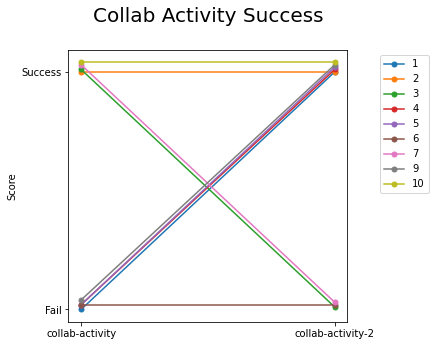

In [12]:
students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.01

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 5))

prelist = list()
postlist = list()
for i in students:
    temp = cdf[cdf['student'] == i]
    values = list(temp.is_mst)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.activity, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Collab Activity Success\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(np.arange(0, 2, step=1), ['Fail','Success'])
plt.show()

# Visualizing pretest and postest learning scores.

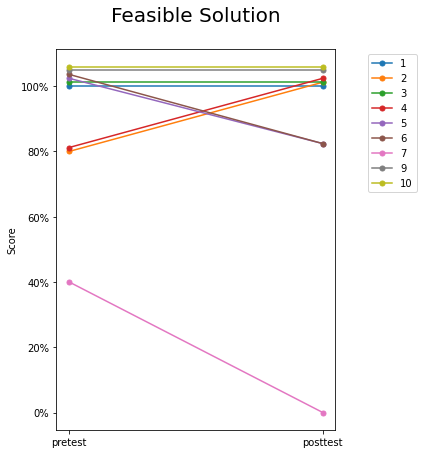

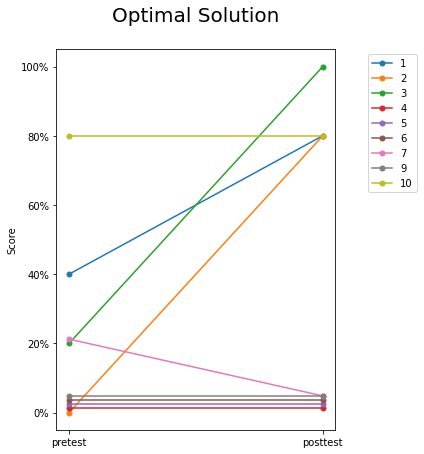

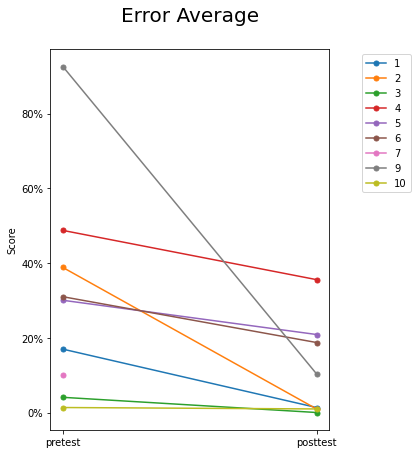

In [13]:
students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.06

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 7))

prelist = list()
postlist = list()
for i in students:
    temp = spandf[spandf['student'] == i]
    values = list(temp.value)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.p_type, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Feasible Solution\n', loc='center', fontsize=20)


leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round((i/5)*100)) + '%' for i in yticks[1:-1]])
plt.show()

# graphing the pretest versus posttest is_mst scores
fig, ax = plt.subplots(1, figsize=(5, 7))

prelist = list()
postlist = list()
for i in students:
    temp = mstdf[mstdf['student'] == i]
    values = list(temp.value)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.p_type, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Optimal Solution\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round((i/5)*100)) + '%' for i in yticks[1:-1]])
plt.show()

# graphing the pretest versus posttest spanning scores
fig, ax = plt.subplots(1, figsize=(5, 7))
for i in students:
    temp = errordf[errordf['student'] == i]
    plt.plot(temp.p_type, temp.value, marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Error Average\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])
plt.show()

# Perform Wilcoxon signed-rank test.

In [14]:
df = learning_df.copy()
df.rename(columns={"pre_error": "pretest_error", "post_error":"posttest_error"}, inplace=True)
display(df)
df.dropna(inplace=True)

categories = ['span','mst', 'error']

for name in categories:
    r = list(df['pretest_' + name])
    o = list(df['posttest_' + name])
    print(name)
    w, p = wilcoxon(r,o,mode="exact") 
    #null hypotehsis says they are the same, p val less than threshold, reject hyp, conclude that post is larger than pretest
    print('Exact:','W=',w,'pvalue=',p)
    a,b = wilcoxon(r,o,mode="exact", alternative="greater")
    print('Greater:','W=',a,'pvalue=',b)

# print(learning_df)

,student,pretest_span,posttest_span,pretest_mst,posttest_mst,pretest_error,posttest_error
1,1,5,5,2,4,0.169524,0.013333
4,2,4,5,0,4,0.388095,0.009524
7,3,5,5,1,5,0.040635,0.000000
6,4,4,5,0,0,0.487302,0.355556
5,5,5,4,0,0,0.300317,0.208730
0,6,5,4,0,0,0.309841,0.187302
3,7,2,0,1,0,0.100000,NaN
2,9,5,5,0,0,0.925714,0.103492
8,10,5,5,4,4,0.013333,0.009524


span
Exact: W= 5.0 pvalue= 1.0
Greater: W= 5.0 pvalue= 0.5
mst
Exact: W= 0.0 pvalue= 0.10247043485974937
Greater: W= 0.0 pvalue= 0.9487647825701253
error
Exact: W= 0.0 pvalue= 0.0078125
Greater: W= 36.0 pvalue= 0.00390625


/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [15]:
with learning_df_pickle_file.open('wb') as handle:
    pickle.dump(learning_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Saved learning_df dataframe to {}'.format(learning_df_pickle_file))

Saved learning_df dataframe to ../processed_data/learning_df.pickle


# Compute Cliff's Deltas.

In [16]:
categories = ['span', 'mst', 'error']

for name in categories:
    r = list(df['pretest_' + name])
    o = list(df['posttest_' + name])
    print(name)
    # estimate effect size by Cliff's Delta 
    d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
    print('d', d)


span
d 0.0
mst
d 0.265625
error
d -0.578125
